In [1]:
# Librairies
import pandas as pd
import numpy as np
from pickleshare import PickleShareDB

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix 

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp
from plotly.graph_objs import Bar
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Pour garantir la reproductibilité
np.random.seed(42)  # Pour numpy

## Chargement des données
Nous chargeons les données depuis le fichier des données préprarées.

In [24]:
db = PickleShareDB('../prep_data/kity')
sample_df = db['net_sample_for_models']

In [ ]:
# sample_df = db['pca_result_with_labels'] 
# sample_df = sample_df.groupby('label', group_keys=False).apply(
#     lambda x: x.sample(frac=0.1, random_state=42)
# )

/tmp/ipykernel_4617/3687076143.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_df = sample_df.groupby('label', group_keys=False).apply(
/tmp/ipykernel_4617/3687076143.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = sample_df.groupby('label', group_keys=False).apply(


Le type 'scan' d'attaque a tres peu d'entrees, ce qui empeche les modeles. On supprime ce type d'attaque.

In [25]:
to_drop = sample_df[sample_df['label'] == 'scan'].index
sample_df = sample_df.drop(to_drop)

Nous supprimons les colonnes label et label_n pour éviter qu'elles influencent le modele, car ce sont les variables cibles et non pas des caractéristiques.

In [26]:
labels = sample_df[['label', 'label_n']]
sample_df.drop(columns=['label', 'label_n'], inplace=True)

## KNN
Notre dataset est considere de taille moyenne.
Pour accélérer les recherches de voisins les plus proches, on va optimiser le modele avec KD-Tree.

In [27]:
X = sample_df
y_label_n = labels['label_n']
y_label = labels['label']

# Encoder les labels en int
le = LabelEncoder()
y_label_n_encoded = le.fit_transform(y_label_n)

ordered_classes = ['normal', 'DoS','physical fault', 'MITM', 'anomaly']
label_map = {label: idx for idx, label in enumerate(ordered_classes)}
y_label_encoded = [label_map[label] for label in y_label]

# Separer le dataset en training et test
X_train_label_n, X_test_label_n, y_train_label_n, y_test_label_n = train_test_split(X, y_label_n_encoded, test_size=0.2, random_state=42, stratify=y_label_n_encoded)

In [28]:
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X, y_label_encoded, test_size=0.2, random_state=42, stratify=y_label_encoded)

On cherche k optimal par validation croisee.
(code commentee car prends beaucoup de temps a tourner, environ 70 minutes)

In [ ]:
"""
param_grid = {'n_neighbors': range(1, 20)}
knn = KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1)
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
"""

{'n_neighbors': 14}


In [29]:
# Initialser et entrainer le classificateur KNN pour label_n
knn = KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree', n_jobs=-1)
knn.fit(X_train_label_n, y_train_label_n)

# Predictions
y_pred_label_n = knn.predict(X_test_label_n)

In [30]:
# Initialser et entrainer le classificateur KNN pour label
knn.fit(X_train_label, y_train_label)

# Predictions
y_pred_label = knn.predict(X_test_label)

## Evaluation

In [32]:
def tpr_tnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  
    return tpr, tnr

### Prédiction pour label_n

#### Données équilibrées

In [33]:
# Métriques pour les données équilibrées
precision = precision_score(y_test_label_n, y_pred_label_n, average='binary')
recall = recall_score(y_test_label_n, y_pred_label_n, average='binary')
accuracy = accuracy_score(y_test_label_n, y_pred_label_n)
tpr, tnr = tpr_tnr(y_test_label_n, y_pred_label_n)

print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"TPR (Sensibilité) : {tpr:.2f}")
print(f"TNR (Spécificité) : {tnr:.2f}")
print(f"Exactitude (Accuracy) : {accuracy:.2f}")

Précision : 0.95
Rappel : 0.58
TPR (Sensibilité) : 0.58
TNR (Spécificité) : 0.98
Exactitude (Accuracy) : 0.82


#### Données déséquilibrées 

In [34]:
# Métriques pour les données déséquilibrées
f1 = f1_score(y_test_label_n, y_pred_label_n, average='binary')
balanced_acc = balanced_accuracy_score(y_test_label_n, y_pred_label_n)
mcc = matthews_corrcoef(y_test_label_n, y_pred_label_n)

print(f"F1-Score : {f1:.2f}")
print(f"Précision équilibrée : {balanced_acc:.2f}")
print(f"Coefficient de Matthews : {mcc:.2f}")

F1-Score : 0.72
Précision équilibrée : 0.78
Coefficient de Matthews : 0.64


#### Matrice de confusion 

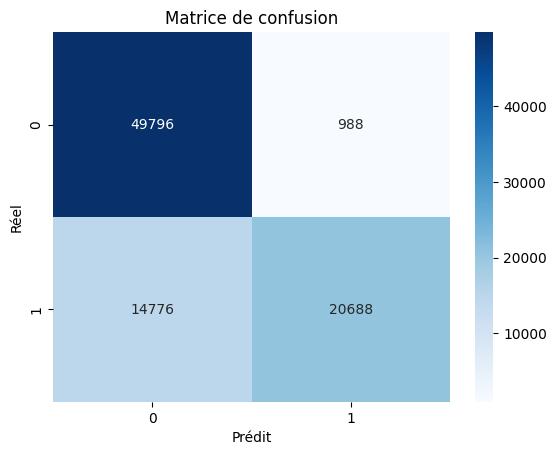

In [35]:
# Matrice de confusion
cm = confusion_matrix(y_test_label_n, y_pred_label_n)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

### Prédiction pour label

#### Données équilibrées

In [36]:
# Métriques pour les données équilibrées
precision = precision_score(y_test_label, y_pred_label, average='macro')
recall = recall_score(y_test_label, y_pred_label, average='macro')
accuracy = accuracy_score(y_test_label, y_pred_label)

print(f"Précision : {precision:.2f}")
print(f"Rappel : {recall:.2f}")
print(f"Exactitude (Accuracy) : {accuracy:.2f}")

Précision : 0.46
Rappel : 0.40
Exactitude (Accuracy) : 0.82


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Données déséquilibrées 

In [37]:
# Métriques pour les données déséquilibrées
f1 = f1_score(y_test_label, y_pred_label, average='macro')
balanced_acc = balanced_accuracy_score(y_test_label, y_pred_label)
mcc = matthews_corrcoef(y_test_label, y_pred_label)

print(f"F1-Score : {f1:.2f}")
print(f"Précision équilibrée : {balanced_acc:.2f}")
print(f"Coefficient de Matthews : {mcc:.2f}")

F1-Score : 0.38
Précision équilibrée : 0.40
Coefficient de Matthews : 0.68


#### Matrice de confusion 

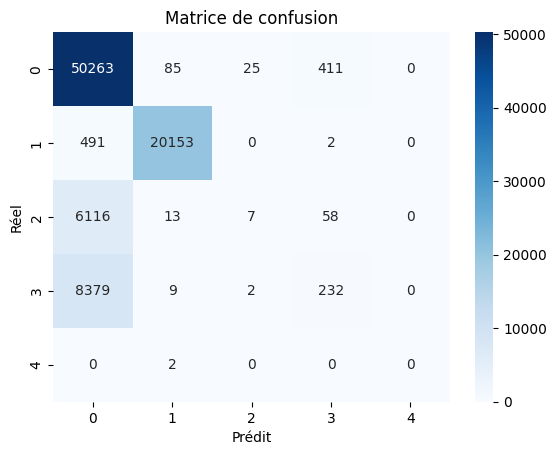

In [38]:
# Matrice de confusion
cm = confusion_matrix(y_test_label, y_pred_label)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()